## Imports

In [1]:
import pyxdf 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from lmfit.models import ExponentialModel, Model

## Function Definitions

Predicted pupil dilation, $d(Y)$, caused by luminance $Y$, is computed with the following equation: $𝑑(𝑌) = 𝑎 · 𝑒^{−𝑏·𝑌} + c$

In [2]:
def pupil_func(x, a, b, c):
    return a * np.exp(-b * x) + c

## Load Data

Load the data from the xdf file for a single participant.

In [3]:
streams, header = pyxdf.load_xdf('./Path_Data/ID_109.xdf')

dfs = {}
for stream in streams:
    stream_name = stream['info']['name'][0]
    stream_channels = {}
    for i, channels in enumerate(stream['info']['desc'][0]['channels'][0]['channel']):
        stream_channels[channels['label'][0]] = i
    stream_data = stream['time_series']
    #example of data layout
    #stream_name: LuminanceStream
    #stream_channels: {'UserID': 0, 'BlockID': 1, 'ModelID': 2, 'MethodID': 3, 'Luminance': 4}
    #stream_data: [[1.0000000e+02 0.0000000e+00 9.9000000e+01 9.9000000e+01 1.1425743e-02][1.0000000e+02 0.0000000e+00 9.9000000e+01 9.9000000e+01 1.1425743e-02][1.0000000e+02 0.0000000e+00 9.9000000e+01 9.9000000e+01 1.1425743e-02]
    data_dict= {}
    for key in stream_channels.keys():
        data_dict[key] = np.array(stream_data)[:, stream_channels[key]]
    time_stamps = np.array(stream['time_stamps'])
    for i in range(len(time_stamps)):
        time_stamps[i] = round(time_stamps[i], 4)
    data_dict['time'] = time_stamps
    dfs[stream_name] = pd.DataFrame(data_dict)
    dfs[stream_name].drop_duplicates(subset=['time'], keep='first', inplace=True)
    dfs[stream_name].reset_index(drop=True, inplace=True)

In [4]:
calibration_events = dfs['ExperimentStream'].loc[(dfs['ExperimentStream']['EventType'] == 'CalibrationColorChange') | (dfs['ExperimentStream']['SceneEvent'] == 'Calibration'), ['time','SceneEvent', 'EventType']]
calibration_events.reset_index(drop=True, inplace=True)
calibration_events['time'] = pd.to_timedelta(calibration_events['time'], unit='s')
start_time = calibration_events.loc[0, 'time']

pupil =  dfs['GazeStream'].loc[( dfs['GazeStream']['LeftEyeIsBlinking']==0) & ( dfs['GazeStream']['RightEyeIsBlinking']==0) & ( dfs['GazeStream']['LeftPupilDiameter']>0) & ( dfs['GazeStream']['RightPupilDiameter']>0), ['time', 'MethodID', 'ModelID', 'LeftPupilDiameter', 'RightPupilDiameter']]
pupil.reset_index(drop=True, inplace=True)
lum = dfs['LuminanceStream'].loc[:, ['time', 'MethodID', 'ModelID', 'Luminance']]
lum.reset_index(drop=True, inplace=True)

pupil_lum_time_intersection = np.intersect1d(pupil['time'], lum['time'])
pupil = pupil[pupil['time'].isin(pupil_lum_time_intersection)]
lum = lum[lum['time'].isin(pupil_lum_time_intersection)]
pupil.reset_index(drop=True, inplace=True)
lum.reset_index(drop=True, inplace=True)

pupil_calib =  pupil.loc[(pupil['MethodID']>98.0), ['time', 'LeftPupilDiameter', 'RightPupilDiameter']]
pupil_calib['time'] = pd.to_timedelta(pupil_calib['time'], unit='s')
pupil_calib.reset_index(drop=True, inplace=True)

lum_calib = lum.loc[(lum['MethodID']>98.0), ['time', 'Luminance']]
lum_calib['time'] = pd.to_timedelta(lum_calib['time'], unit='s')
lum_calib.reset_index(drop=True, inplace=True)

pup_lum_df = pd.DataFrame()
pup_lum_df['time'] = pd.to_timedelta(lum['time'], unit='s')
pup_lum_df['delta_time'] = pd.to_timedelta(lum['time'] - dfs['ExperimentStream']['time'][0], unit='s')
pup_lum_df['Luminance'] = lum['Luminance']
pup_lum_df['pupilDiameter'] = 0.5 * (pupil['LeftPupilDiameter'] + pupil['RightPupilDiameter'])
pup_lum_df.resample('0.1s', on='time', ).mean()

accom_time = pd.to_timedelta(0.5, unit='s')

In [5]:
calib_data = {}
for i in range(8):
    if i == 7:
        calib_data[i] = pup_lum_df.loc[(pup_lum_df['time']>=calibration_events.loc[i, 'time']) & (pup_lum_df['time']<=pupil_calib['time'].iloc[-1]), ['time', 'Luminance', 'pupilDiameter']]
    else:
        calib_data[i] = pup_lum_df.loc[(pup_lum_df['time']>=calibration_events.loc[i, 'time']) & (pup_lum_df['time']<=calibration_events.loc[i+1, 'time']), ['time', 'Luminance', 'pupilDiameter']]

for i in range(8):
    calib_data[i].reset_index(drop=True, inplace=True)
    calib_data[i]['time'] = calib_data[i]['time'] - calib_data[i]['time'][0]
    calib_data[i]=calib_data[i].loc[(calib_data[i]['time']>=accom_time), ['time', 'Luminance', 'pupilDiameter']]
    calib_data[i].reset_index(drop=True, inplace=True)

calibration_data = pd.concat(calib_data, keys=range(8))
calibration_data.drop(columns=['time'], inplace=True)
calibration_data.reset_index(level=1, drop=True, inplace=True)
calibration_data = calibration_data.groupby(level=0).mean()
calibration_data.sort_values(by=['Luminance'], inplace=True)
calibration_data.reset_index(drop=True, inplace=True)
print(calibration_data)


   Luminance  pupilDiameter
0   0.000000       4.211849
1   0.011426       4.349858
2   0.068525       3.368985
3   0.205574       2.870774
4   0.369418       2.705929
5   0.498880       2.567750
6   0.666279       2.667642
7   0.761598       2.324594


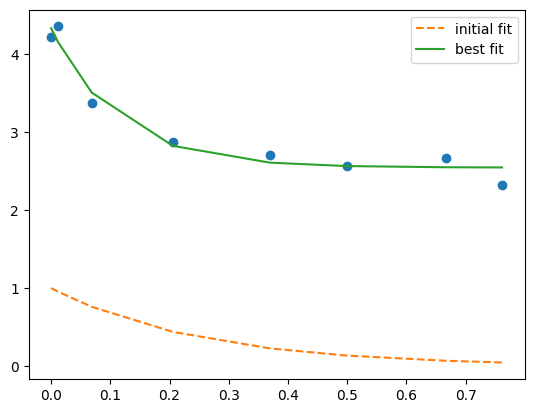

In [6]:
#𝑎, 𝑏, and 𝑐 were fitted using least squares optimization with empirically determined bounds of a: [1, 4], b: [4, 8], and c: [0, 8]
x_data = calibration_data['Luminance']
y_data = calibration_data['pupilDiameter']

exp_mod = Model(pupil_func)
params = exp_mod.make_params(a=1, b=4, c=0)

result = exp_mod.fit(y_data, params, x=x_data)
a = result.params['a'].value
b = result.params['b'].value
c = result.params['c'].value

plt.plot(x_data, y_data, 'o')
plt.plot(x_data, result.init_fit, '--', label='initial fit')
plt.plot(x_data, result.best_fit, '-', label='best fit')
plt.legend()
plt.show()

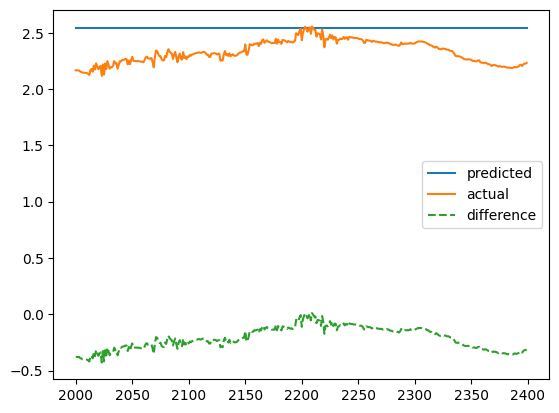

In [7]:
start = 2000
end = 2400
plot_x = pup_lum_df[start:end]['Luminance']
predicted_plr = pupil_func(plot_x, a, b, c)

plot_dif = pup_lum_df[start:end]['pupilDiameter'] - predicted_plr

plt.plot(pup_lum_df.index[start:end], predicted_plr, '-', label='predicted')
plt.plot(pup_lum_df.index[start:end], pup_lum_df[start:end]['pupilDiameter'], '-', label='actual')
plt.plot(pup_lum_df.index[start:end], plot_dif, '--', label='difference')
plt.legend()


In [9]:
navigation_events = dfs['ExperimentStream'].loc[(dfs['ExperimentStream']['SceneEvent'] == 'NavigationComplete') | (dfs['ExperimentStream']['SceneEvent'] == 'Navigation_Trial'), ['time','SceneEvent', 'EventType', 'ModelID', 'MethodID']]
navigation_events.reset_index(drop=True, inplace=True)
navigation_events['time'] = pd.to_timedelta(navigation_events['time'] - dfs['ExperimentStream']['time'][0], unit='s')